### imports & loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from scipy.stats import ttest_rel

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

In [2]:
df = pd.read_csv('/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/intfloat/e5-base-v2/explanation_deepseek_1_bm25_combinedScore_search_changedWeights/augmented_retrieval_analysis.csv')

In [3]:
df.columns

Index(['query_id', 'query', 'retrieved_doc_id', 'retrieved_doc',
       'retrieved_code', 'retrieved_explanation', 'score',
       'ground_truth_relevance'],
      dtype='object')

In [4]:
len(df) # ?

145740

In [5]:
df.describe()

,score,ground_truth_relevance
count,145740.000000,145740.000000
mean,0.762357,0.003252
std,0.062887,0.056937
min,0.510272,0.000000
25%,0.726106,0.000000
50%,0.763648,0.000000
75%,0.800122,0.000000
max,1.000000,1.000000


In [6]:
ground_truth_map = df[df["ground_truth_relevance"] == 1].set_index("query")["retrieved_explanation"].to_dict()

df["ground_truth_explanation"] = df["query"].map(ground_truth_map).fillna("")

# if for a query ground truth is not in top 1000 then this col will be marked as ""

In [7]:
df.isna().sum()

query_id                    0
query                       0
retrieved_doc_id            0
retrieved_doc               0
retrieved_code              0
retrieved_explanation       0
score                       0
ground_truth_relevance      0
ground_truth_explanation    0
dtype: int64

### How many docs before the first ground truth appears?

In [8]:
ground_truth_ranks = []

for query_id, group in df.groupby("query_id"):
    group = group.reset_index()  
    first_index = group.index[0] 
    
    # Find ground truth occurrences
    relevant_docs = group[group["ground_truth_relevance"] == 1]
    
    if not relevant_docs.empty:
        first_gt_rank = relevant_docs.index.min() - first_index + 1  # Rank calculation
        total_relevant = len(relevant_docs)
    else:
        first_gt_rank = 1001
        total_relevant = 0

    ground_truth_ranks.append({
        "Query ID": query_id,
        "First GT Rank": first_gt_rank,
        "Total GT": total_relevant
    })
    
result_df = pd.DataFrame(ground_truth_ranks)
result_df.head()

,Query ID,First GT Rank,Total GT
0,q20105,131,1
1,q20106,257,1
2,q20107,134,1
3,q20108,4,1
4,q20109,135,1


In [9]:
valid_ranks = result_df[result_df["First GT Rank"] != 1001]["First GT Rank"]

average_first_gt_rank = valid_ranks.mean()

print(f"Average First GT Rank: {average_first_gt_rank:.4f}")

Average First GT Rank: 75.9726


In [10]:
result_df['First GT Rank'].describe()

count     500.000000
mean      124.074000
std       220.328377
min         1.000000
25%        10.750000
50%        62.500000
75%       135.250000
max      1001.000000
Name: First GT Rank, dtype: float64

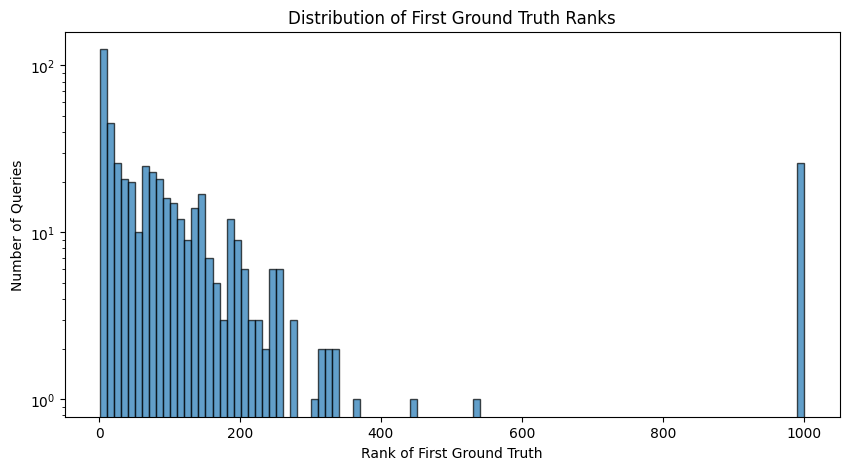

In [11]:
plt.figure(figsize=(10, 5))
plt.hist(result_df['First GT Rank'], bins=np.arange(1, 1002, 10), edgecolor="black", alpha=0.7)
plt.xlabel("Rank of First Ground Truth")
plt.ylabel("Number of Queries")
plt.title("Distribution of First Ground Truth Ranks")
plt.yscale("log")  
plt.show()


In [29]:
invalid_ranks = result_df[result_df["First GT Rank"] == 1001]["First GT Rank"]
print(f"Queries for which GT not retrieved: {len(invalid_ranks)} out of {len(result_df)} ({len(invalid_ranks)/len(result_df) * 100})%")

Queries for which GT not retrieved: 26 out of 500 (5.2)%


In [12]:
first_gt_ranks = result_df['First GT Rank'].tolist()

mrr = np.mean([1/rank for rank in first_gt_ranks if rank <= 1000])
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")


Mean Reciprocal Rank (MRR): 0.1445


### Finding patterns in query results

In [13]:
correct_retrievals = df[df["ground_truth_relevance"] == 1]
incorrect_retrievals = df[df["ground_truth_relevance"] == 0]

/tmp/ipykernel_1114284/4025150044.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
/tmp/ipykernel_1114284/4025150044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)


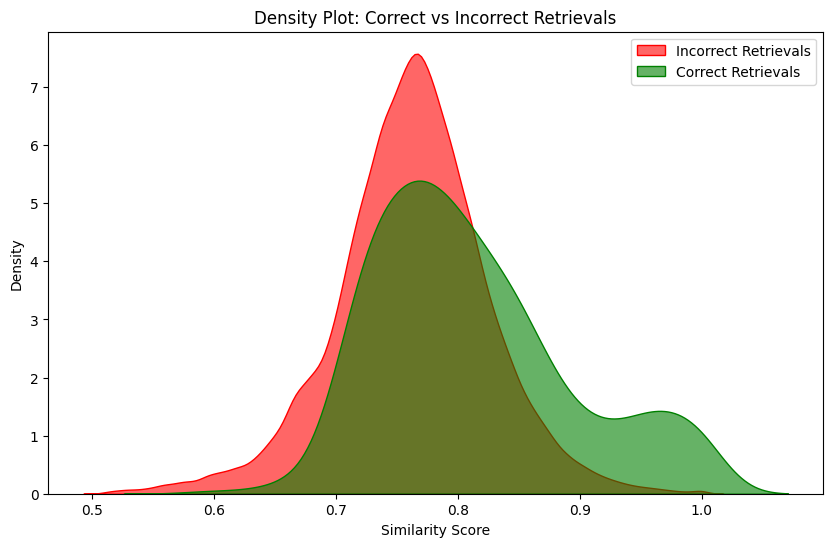

In [14]:
plt.figure(figsize=(10, 6))
sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)

plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title('Density Plot: Correct vs Incorrect Retrievals')
plt.legend()
plt.show()


In [15]:
df['top_retrieved_score'] = df.groupby('query')['score'].transform('max')
df['score_difference'] = df['top_retrieved_score'] - df['score']

In [16]:
df['score_difference'].describe()

count    145740.000000
mean          0.182165
std           0.056711
min           0.000000
25%           0.148426
50%           0.183074
75%           0.216967
max           0.446810
Name: score_difference, dtype: float64

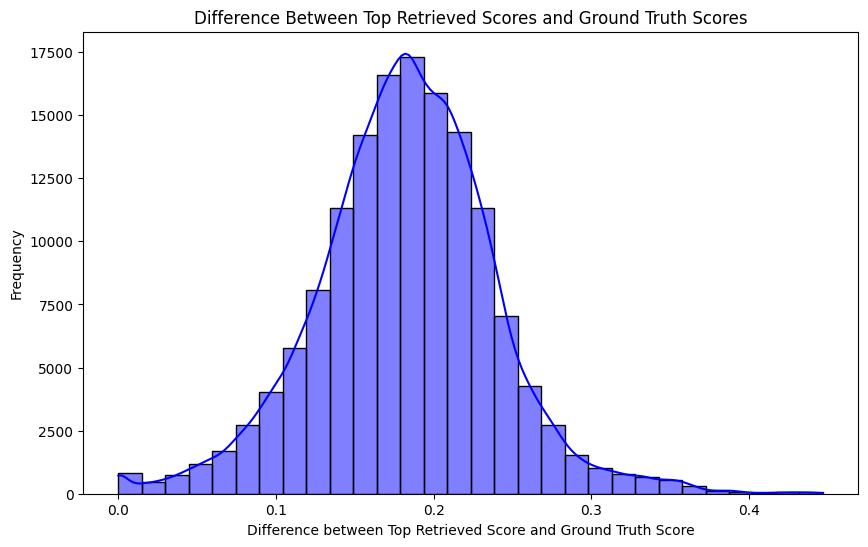

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['score_difference'], bins=30, kde=True, color='b')
plt.xlabel('Difference between Top Retrieved Score and Ground Truth Score')
plt.ylabel('Frequency')
plt.title('Difference Between Top Retrieved Scores and Ground Truth Scores')
plt.show()

### Analyzing Term Frequencies & BM25 Impact

In [18]:
def token_overlap(query, explanation):
    query_tokens = set(word for word in query.lower().split() if word not in stop_words)
    explanation_tokens = set(word for word in explanation.lower().split() if word not in stop_words)
    return len(query_tokens.intersection(explanation_tokens))

In [19]:
df["retrieved_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["retrieved_explanation"]), axis=1)

df["ground_truth_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["ground_truth_explanation"]) , axis=1)

In [20]:
df

,query_id,query,retrieved_doc_id,retrieved_doc,retrieved_code,retrieved_explanation,score,ground_truth_relevance,ground_truth_explanation,top_retrieved_score,score_difference,retrieved_overlap,ground_truth_overlap
0,q20105,sort by a token in string python,d19144,get document frequency from tokenized lists py...,"def _sum_cycles_from_tokens(self, tokens: List...",The docstring and code snippet both describe a...,0.857904,0,The doc and code both clean a string by splitt...,0.857904,0.000000,1,1
1,q20105,sort by a token in string python,d5611,how to sort a array in python,"def arglexsort(arrays):\n """"""\n Returns ...",The docstring explains that `arglexsort` is a ...,0.848533,0,The doc and code both clean a string by splitt...,0.857904,0.009371,1,1
2,q20105,sort by a token in string python,d1629,loop through tokens in a string python,"def tokenize(string):\n """"""Match and yield ...",The docstring and code snippet are explaining ...,0.832003,0,The doc and code both clean a string by splitt...,0.857904,0.025901,2,1
3,q20105,sort by a token in string python,d6352,upper case in a list python,"def upcaseTokens(s,l,t):\n """"""Helper parse ...",The doc string and code are meant to convert t...,0.819067,0,The doc and code both clean a string by splitt...,0.857904,0.038837,2,1
4,q20105,sort by a token in string python,d19688,indexes of sorted list python,"def _index_ordering(redshift_list):\n ""...",The doc string explains that the function sort...,0.816637,0,The doc and code both clean a string by splitt...,0.857904,0.041267,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145735,q20604,how do i unzip file in python,d9508,how to instanticate a bytes like object python,"def loadb(b):\n """"""Deserialize ``b`` (insta...","To deserialize bytes into Python objects, use ...",0.717247,0,The code snippet defines a function `_unzip_ha...,0.878522,0.161274,1,1
145736,q20604,how do i unzip file in python,d19938,python good way to load a yaml file,"def load_yaml(filepath):\n """"""Convenience f...","To load a YAML-encoded file, use the `yaml.loa...",0.717165,0,The code snippet defines a function `_unzip_ha...,0.878522,0.161357,1,1
145737,q20604,how do i unzip file in python,d166,centos yum remove python,"def update(kernel=False):\n """"""\n Upgrad...",The doc and code are meant to uninstall packag...,0.716965,0,The code snippet defines a function `_unzip_ha...,0.878522,0.161557,1,1
145738,q20604,how do i unzip file in python,d1505,how to write to create a file in source code t...,"def write_file(filename, content):\n """"""Cre...",The doc and code are intended to create a file...,0.716616,0,The code snippet defines a function `_unzip_ha...,0.878522,0.161906,2,1


In [21]:
print(token_overlap(df['query'][0],df['retrieved_explanation'][0]))

1


In [22]:
retrieved_avg = df["retrieved_overlap"].mean()
ground_truth_avg = df["ground_truth_overlap"].mean()

print(f"Average Token Overlap - Retrieved Explanations: {retrieved_avg:.2f}")
print(f"Average Token Overlap - Ground Truth Explanations: {ground_truth_avg:.2f}")

Average Token Overlap - Retrieved Explanations: 0.84
Average Token Overlap - Ground Truth Explanations: 1.72


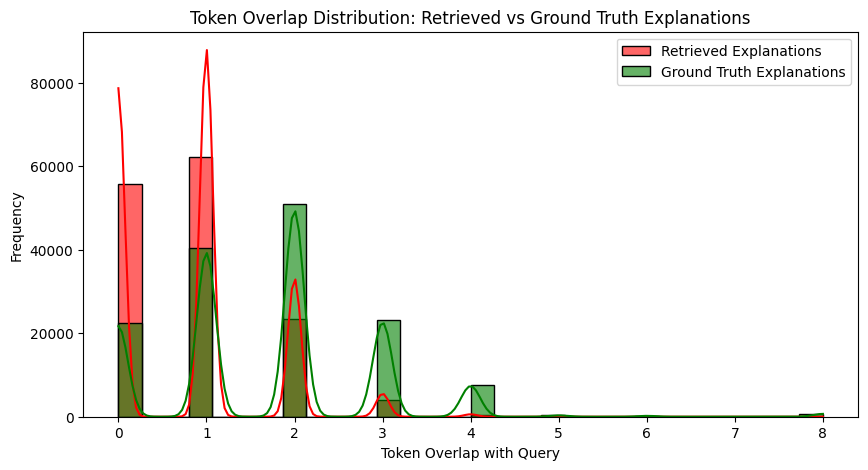

In [23]:
plt.figure(figsize=(10, 5))
sns.histplot(df["retrieved_overlap"], bins=30, color="red", label="Retrieved Explanations", alpha=0.6, kde=True)
sns.histplot(df["ground_truth_overlap"], bins=30, color="green", label="Ground Truth Explanations", alpha=0.6, kde=True)
plt.xlabel("Token Overlap with Query")
plt.ylabel("Frequency")
plt.title("Token Overlap Distribution: Retrieved vs Ground Truth Explanations")
plt.legend()
plt.show()

In [24]:
avg_query_token_size = df["query"].apply(lambda x: len([word for word in x.lower().split() if word not in stop_words])).mean()

print(f"Average Query Token Size: {avg_query_token_size:.2f}")

Average Query Token Size: 4.61


In [25]:
higher_gt_overlap = (df["ground_truth_overlap"] > df["retrieved_overlap"]).sum()
total_rows = len(df)

print(f"Ground Truth Overlap > Retrieved Overlap: {higher_gt_overlap}/{total_rows} ({(higher_gt_overlap/total_rows)*100:.2f}%)")

Ground Truth Overlap > Retrieved Overlap: 88190/145740 (60.51%)
